In [98]:
import nltk
nltk.download('punkt')

import re
import os

import json
import random
import pandas as pd
import plotly.express as px

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\harsi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [99]:
def find_industry(sic):
    sic_num = int(sic)
    if sic_num < 1000:
        return 0
    if sic_num < 1500:
        return 1
    if sic_num < 1800:
        return 2
    if sic_num < 4000:
        return 3
    if sic_num < 5000:
        return 4
    if sic_num < 5200:
        return 5
    if sic_num < 6000:
        return 6
    if sic_num < 6800:
        return 7
    if sic_num < 9000:
        return 8
    else:
        return 9

In [100]:
years = dict()

industries = [dict() for _ in range (10)]

directory = "./10K_item1a_PERMNO_2015_sic_tic"

all_filings = os.listdir(directory)

print("Organizing data...")
for filing in all_filings:
    
    considered_filing = open(directory + "/" + filing, 'r')
    data = json.load(considered_filing)

    year_of_filing = (data["filing_date"])[0:4]

    if year_of_filing not in years:
        years[year_of_filing] = [dict() for _ in range(10)]

    industries = years[year_of_filing]
    
    sic_num = data["SIC"]
    cik = data["cik"]
    risk_factors = data["item_1A"]

    industry_set = industries[find_industry(sic_num)]

    industry_set[cik] = nltk.sent_tokenize(risk_factors[22:])

    considered_filing.close()

print("Data is organized.")
# for key in years:
#     print(key)

Organizing data...
Data is organized.
2015
2016
2017
2018
2019
2020
2021
2022


In [140]:
sample_data = dict()

for year, industries in years.items():
    sample_data[year] = [dict() for _ in range (10)]
    
    for i, industry in enumerate(industries):
        ciks = list(industry.keys())
        sample_size = min(10, len(ciks))
        sample_ciks = random.sample(ciks, sample_size)

        sample_data[year][i] = sample_ciks

# for year, industries in sample_data.items():
#     print("Year: " + year)

#     for i, sample_ciks in enumerate(industries):
#         print(f"Industry {i}: {sample_ciks}")

In [141]:
keyword_dict = {
    "attack" : {
        "cyber" : 1,
        "network": 1,
        "system": 1,
        "product": 1,
        "service": 1,
        "datacenter": 1,
        "infrastructure": 1,
        "terror": -1,
        "war": -1, 
        "contraband": -1,
        "bomb": -1
    },
    "threat" : {
        "cyber" : 1,
        "network": 1,
        "system": 1,
        "product": 1,
        "service": 1,
        "datacenter": 1,
        "infrastructure": 1,
        "terror": -1,
        "simulator": -1, 
        "disease": -1,
        "legal action": -1,
        "competitor": -1
    },
    "computer" : {
        "malware": 1,
        "virus": 1,
        "intrusion": 1,
        "fire": -1,
        "product sale": -1,
        "warranty claim": -1
    },
    "information system" : {
        "malware": 1,
        "virus": 1,
        "intrusion": 1,
        "fire": -1,
        "product sale": -1,
        "warranty claim": -1
    },
    "malicious" : {
        "malware": 1,
        "virus": 1,
        "intrusion": 1,
        "fire": -1,
        "product sale": -1,
        "warranty claim": -1
    },
    "breaches" : {
        "fiduciary duty": -1,
        "fiduciary duties": -1,
        "covenant": -1,
        "credit": -1,
        "agreement": -1,
        "obligation": -1
    },
    "hacker" : {
        "fiduciary": -1,
        "warrant": -1,
        "regulation": -1,
        "contract": -1
    },
    "hacking" : {
        "fiduciary": -1,
        "warrant": -1,
        "regulation": -1,
        "contract": -1
    },
    "social engineering" : {
        "fiduciary": -1,
        "warrant": -1,
        "regulation": -1,
        "contract": -1
    },
    "denial of service" : {
        "fiduciary": -1,
        "warrant": -1,
        "regulation": -1,
        "contract": -1
    },
    "cyberattack" : {
        "fiduciary": -1,
        "warrant": -1,
        "regulation": -1,
        "contract": -1
    },
    "cybersecurity" : {
        "fiduciary": -1,
        "warrant": -1,
        "regulation": -1,
        "contract": -1
    }
}

In [142]:
def sentence_score(sentence):
    lower_sentence = sentence.lower()
    score = 0

    for keyword, relevence_test in keyword_dict.items():
        if re.search(r'\b' + re.escape(keyword) + r'\w*\b', lower_sentence):
            #print(keyword)
            #score = score + 1
        
            for relevent_word, word_score in relevence_test.items():
                if re.search(r'\b' + re.escape(relevent_word) + r'\w*\b', lower_sentence):
                    score = score + word_score
                    #print("\t" + relevent_word + ": " + str(word_score))

            #print("\n")

    return score

In [143]:
risk_dict = {}

for year, industries in sample_data.items():
    risk_dict[year] = [dict() for _ in range (10)]
    
    for i, industry in enumerate(industries):
        risk_dict[year][i] = {
            "industry_risk_sentences": 0,
            "industry_total_sentences": 0,
            **{
                cik: {
                    "total_sentences": 0,
                    "risk_sentences": 0
                }
                for cik in sample_data[year][i]
            }
        }

In [144]:
for year, industries in sample_data.items():
    path_name_year = f"./{year}"
    
    for i, industry in enumerate(industries):
        path_name = f"{path_name_year}/{i}"
        os.makedirs(path_name)
        
        for cik in sample_data[year][i]:
            risk_counter = 0
            total_sentences = 0
            
            for sentence in years[year][i][cik]:
                total_sentences = total_sentences + 1
                if sentence_score(sentence) > 0:
                    file_to_append_to = f"{path_name}/{cik}-{year}.txt"

                    accessed_file = open(file_to_append_to, "a", encoding="utf-8")
                    accessed_file.write(sentence.strip() + "\n")
                    accessed_file.close()
                    
                    risk_counter = risk_counter + 1

            if total_sentences > 0:
                risk_dict[year][i][cik]["total_sentences"] = total_sentences
                risk_dict[year][i][cik]["risk_sentences"] = risk_counter
                risk_dict[year][i][cik]["risk_ratio"] = risk_counter / total_sentences

In [145]:
for year, industries in risk_dict.items():
    
    for i, industry in enumerate(industries):
        industry_total_sentences = 0
        industry_risk_sentences = 0

        for cik in risk_dict[year][i]:
            if cik == "industry_risk_sentences" or cik == "industry_total_sentences":
                continue

            industry_total_sentences = industry_total_sentences + risk_dict[year][i][cik]["total_sentences"]
            industry_risk_sentences = industry_risk_sentences + risk_dict[year][i][cik]["risk_sentences"]

        if industry_total_sentences > 0:
            risk_dict[year][i]["industry_risk_sentences"] = industry_risk_sentences
            risk_dict[year][i]["industry_total_sentences"] = industry_total_sentences

In [146]:
industry_records = []
for year, industries in risk_dict.items():
    for i, industry in enumerate(industries):
        industry_records.append({
            "year": int(year),
            "industry": i,
            "industry_risk_sentences": risk_dict[year][i]["industry_risk_sentences"],
            "industry_total_sentences": risk_dict[year][i]["industry_total_sentences"]
        })

industry_df = pd.DataFrame(industry_records)

In [147]:
combined_industry_df = industry_df.groupby("industry")
combined_industry_df = combined_industry_df.agg({
    'industry_risk_sentences': 'sum',
    'industry_total_sentences': 'sum'
})
combined_industry_df["industry_risk"] = (combined_industry_df["industry_risk_sentences"] / combined_industry_df["industry_total_sentences"]).astype(float)

print("Count: " + str(combined_industry_df["industry_risk"].count()))
print("Mean: " + str(combined_industry_df["industry_risk"].mean()))
print("Standard deviation: " + str(combined_industry_df["industry_risk"].std()))
print("Minimum: " + str(combined_industry_df["industry_risk"].min()))
print("Maximum: " + str(combined_industry_df["industry_risk"].max()))
print("Skew: " + str(combined_industry_df["industry_risk"].skew()))
print("Kurtosis: " + str(combined_industry_df["industry_risk"].kurtosis()))

print("1% percentile: " + str(combined_industry_df["industry_risk"].quantile(0.01)))
print("5% percentile: " + str(combined_industry_df["industry_risk"].quantile(0.05)))
print("25% percentile: " + str(combined_industry_df["industry_risk"].quantile(0.25)))
print("50% percentile: " + str(combined_industry_df["industry_risk"].quantile(0.50)))
print("75% percentile: " + str(combined_industry_df["industry_risk"].quantile(0.75)))
print("95% percentile: " + str(combined_industry_df["industry_risk"].quantile(0.95)))
print("99% percentile: " + str(combined_industry_df["industry_risk"].quantile(0.99)))

Count: 10
Mean: 0.009374411980396917
Standard deviation: 0.003105841221744986
Minimum: 0.003664373317379599
Maximum: 0.015227251689345552
Skew: -0.03637353909092603
Kurtosis: 1.1555572930141969
1% percentile: 0.003933271103766362
5% percentile: 0.005008862249313414
25% percentile: 0.007594940443961145
50% percentile: 0.009733466614762609
75% percentile: 0.010595395529841995
95% percentile: 0.013493098665360522
99% percentile: 0.014880421084548547


In [148]:
company_records = []
for year, industries in risk_dict.items():
    for i, industry in enumerate(industries):
        for cik, cik_data in industry.items():
            if cik == "industry_risk_sentences" or cik == "industry_total_sentences":
                continue
            
            company_records.append({
                "year": int(year),
                "industry": i,
                "cik": cik,
                "company_risk_sentences": cik_data["risk_sentences"],
                "company_total_sentences": cik_data["total_sentences"]
            })

company_df = pd.DataFrame(company_records)
company_df["company_risk_ratio"] = company_df["company_risk_sentences"] / company_df["company_total_sentences"]
company_df["company_risk_ratio"] = company_df["company_risk_ratio"].fillna(0)
# print(company_df)

In [158]:
combined_company_df = company_df.groupby(["year", "industry"])

combined_company_df = combined_company_df.agg(
    company_risk_ratio_average = ('company_risk_ratio', 'mean'),
    company_risk_ratio_std = ('company_risk_ratio', 'std')
)

combined_company_df = combined_company_df.reset_index()

sic_mapping = {
    0: "Agriculture, Forestry, and Fishing",
    1: "Mining",
    2: "Construction",
    3: "Manufacturing",
    4: "Transportation and other Utilities",
    5: "Wholesale Trade",
    6: "Retail Trade",
    7: "Finance, Insurance, and Real Estate",
    8: "Services",
    9: "Public Administration"
}

combined_company_df["industry"] = combined_company_df["industry"].replace(sic_mapping)

for year in combined_company_df["year"].unique():
    # print("\nYear: " + str(year))

    year_data = combined_company_df[combined_company_df['year'] == year]
    
    for index, row in year_data.iterrows():
        industry_name = row['industry']
        company_risk_ratio_average = round(row['company_risk_ratio_average'], 4)  
        company_risk_ratio_std = round(row['company_risk_ratio_std'], 4)
        
        # Print the results
        # print("\tIndustry: " + industry_name)
        # print("\t\tRisk Ratio Average: " + str(company_risk_ratio_average))
        # print("\t\tRisk Ratio Std: " + str(company_risk_ratio_std))


Year: 2015

Year: 2016

Year: 2017

Year: 2018

Year: 2019

Year: 2020

Year: 2021

Year: 2022


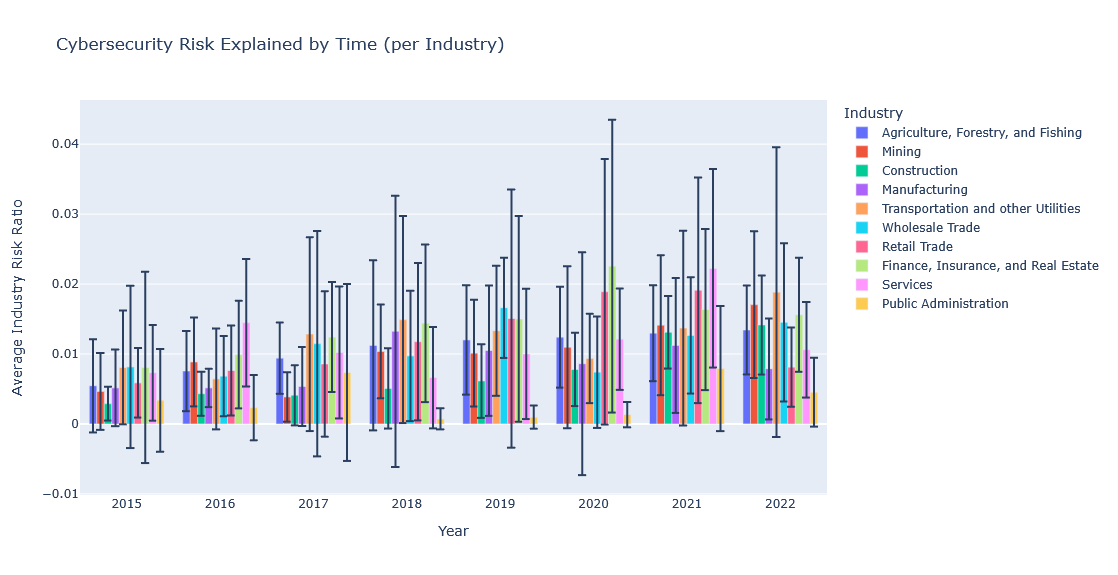

In [155]:
fig = px.bar(
    combined_company_df,
    x = "year",
    y = "company_risk_ratio_average",
    error_y = "company_risk_ratio_std",
    color = "industry",
    barmode = "group",
    title = "Cybersecurity Risk Explained by Time (per Industry)"
)

fig.update_layout(
    xaxis_title = "Year",
    yaxis_title = "Average Industry Risk Ratio",
    legend_title = "Industry",
    height = 575,
    width = 1400
)

fig.show()

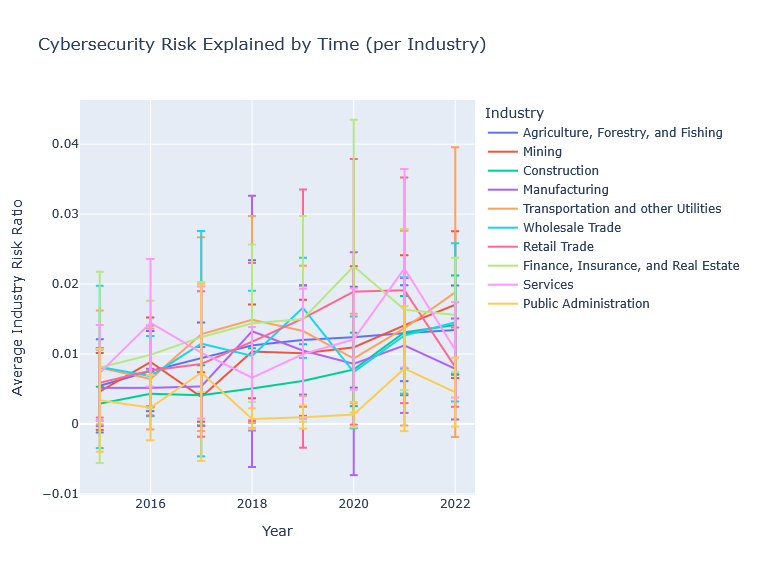

In [157]:
fig = px.line(
    combined_company_df,
    x = "year",
    y = "company_risk_ratio_average",
    error_y = "company_risk_ratio_std",
    color = "industry",
    title = "Cybersecurity Risk Explained by Time (per Industry)"
)

fig.update_layout(
    xaxis_title = "Year",
    yaxis_title = "Average Industry Risk Ratio",
    legend_title = "Industry",
    height = 575,
    width = 1400
)

fig.show()